# Prediction of diabetes with scikit-learn

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, recall_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Enable plotting

In [2]:
%matplotlib inline

In [3]:
sns.set()

About the data

In [4]:
!cat ../data/pima-indians-diabetes.names

1. Title: Pima Indians Diabetes Database

2. Sources:
   (a) Original owners: National Institute of Diabetes and Digestive and
                        Kidney Diseases
   (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
                          Research Center, RMI Group Leader
                          Applied Physics Laboratory
                          The Johns Hopkins University
                          Johns Hopkins Road
                          Laurel, MD 20707
                          (301) 953-6231
   (c) Date received: 9 May 1990

3. Past Usage:
    1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
       Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
       the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
       on Computer Applications and Medical Care} (pp. 261--265).  IEEE
       Computer Society Press.

       The diagnostic, binary-valued variable investigated is whether the
       patien

Load data and have initial look

In [5]:
df = pd.read_csv('../data/pima-indians-diabetes-data.csv', index_col=[0])

In [6]:
df.head()

,num_pregnant,plasma_glucose_c,blood_presure,skin_fold_thickness,serum_insulin,BMI,diabetes_pedigree_funct,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.describe()

,num_pregnant,plasma_glucose_c,blood_presure,skin_fold_thickness,serum_insulin,BMI,diabetes_pedigree_funct,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
len(df[df['class'] == 1]), len(df[df['class'] == 0])

(268, 500)

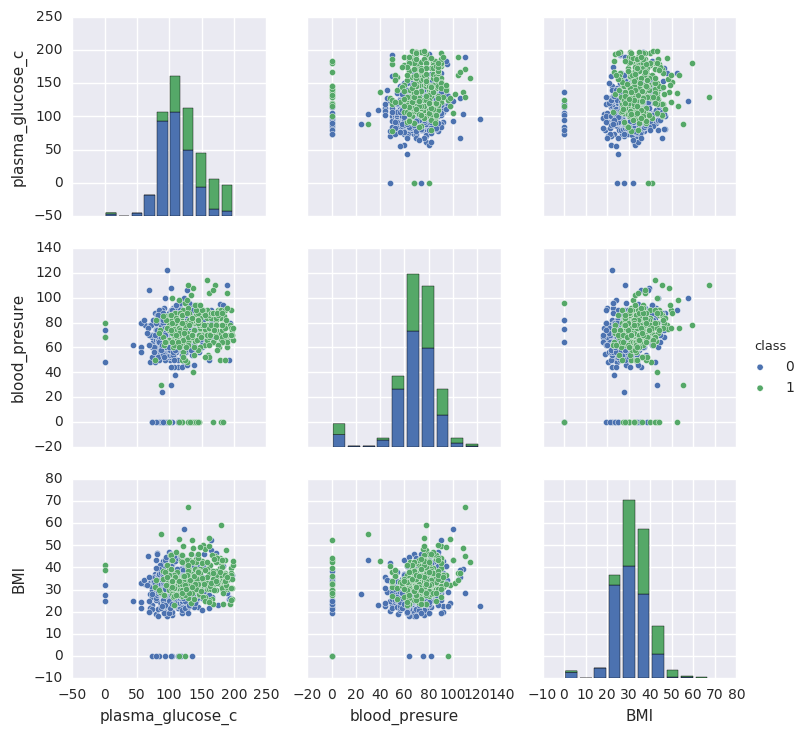

In [9]:
sns.pairplot(df, x_vars=['plasma_glucose_c', 'blood_presure', 'BMI'], 
             y_vars=['plasma_glucose_c', 'blood_presure', 'BMI'], hue='class')

Data in the table is organized the following way: 

| Samples  | Feature 1 | Feature 2 | ... | Class |
|----------|-----------|-----------|-----|-------|
| Sample 1 |     12    |    600    | ... |   1   |
| Sample 2 |      9    |    932    | ... |   0   |

Extract values for the machine learning.  
**X** - are features  
**y** - class, target value  

In [10]:
X = df.drop('class', axis=1).values
y = df['class'].values

Split the data in training and test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Train the model

In [12]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predict **y** (class) on test set and probabilities that sample belongs to each of two classes.

In [13]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

Helper functions that facilitate plotting

In [14]:
def plot_hist(y, scores, title, size=(1.5,1.5)):
    fig = plt.figure(figsize=size, dpi=80)
    axes = fig.add_axes([0, 0, 1, 1])
    bins = np.linspace(0, 1, 11)
    axes.hist([x[0] for x in zip(scores, y) if x[1] == 1], bins, alpha=0.5, color= 'b')
    axes.hist([x[0] for x in zip(scores, y) if x[1] == 0], bins, alpha=0.5, color= 'r')
    axes.vlines(0.5, 0, np.histogram(scores, bins)[0].max(), color='black', linestyles='--')
    axes.set_ylim((0, np.histogram(scores, bins)[0].max()))
    axes.set_xlabel(title)
    axes.set_ylabel('#')
    return fig

def plot_ROC(observations, probabilities, title="", labels=True, size='auto'):
    """
    Creates ROC plot from observations (y_test) and probabilities (y_pred_proba)
    title -- title of the plot
    size -- tuple, size in inch, defaults to 'auto'
    labels -- toogle display of title and x and y labels and tick labels
    """
    if size is 'auto':
        fig = plt.figure()
    else:
        fig = plt.figure(num=None, figsize=size, dpi=80)
    axes = fig.add_axes([0, 0, 1, 1])
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    axes.plot(fpr, tpr)
    axes.plot([0, 1], [0, 1], 'k--')
    axes.set_aspect('equal')
    if labels:
        axes.set_title(title)
        axes.set_xlabel('False Positive Rate')
        axes.set_ylabel('True Positive Rate')
    else:
        axes.get_xaxis().set_ticks([])
        axes.get_yaxis().set_ticks([])
    return fig

Plot distribution of probabilities

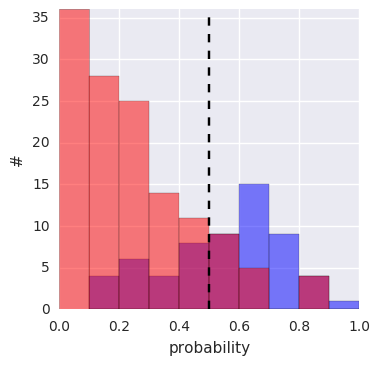

In [15]:
plot_hist(y_test, y_pred_proba.T[1], 'probability', size=(3,3));

Plot ROC curve

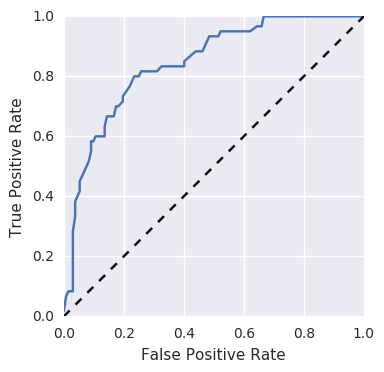

In [16]:
plot_ROC(y_test, y_pred_proba.T[1], size=(3,3));

In [17]:
print("AUC: %.3f" % roc_auc_score(y_test, y_pred_proba.T[1]))

AUC: 0.843


In [18]:
confusion_matrix(y_test, y_pred)

array([[114,  18],
       [ 24,  36]])